In [121]:
# for one year interval, define companies into groups of high, medium and low based on their patent information
# for each category, find the average return of the group for the future one year and see trend.

%config InlineBackend.figure_format='retina'
%matplotlib inline
import dill
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib import rc
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output
import datetime
from tqdm import tqdm


font = {'color':  'black',
        'weight': 'normal',
        'size': 10,
        'style': 'italic'
        }

matplotlib.rcParams.update({'font.family': 'sans-serif','font.sans-serif': 'Arial', 'mathtext.fontset': 'stix',
                           'font.size':'12'})
matplotlib.rcParams['axes.linewidth'] = 1.3
formatter = ticker.ScalarFormatter(useMathText=True)


In [4]:
body = pd.read_csv('ee_or_matched.csv',index_col=0, dtype=str)

In [5]:
# to prove inside record there are both companies and people as assignor
# google = body[body['ticker']=='GOOG']
# google[['convey_text','or_name','exec_dt','ticker','or_name_matched']]

In [290]:
# for example, take year 2013 as the reference year, predict 2014

lowerbd = body[body['exec_dt']>'2014']
dfpatent = lowerbd[lowerbd['exec_dt']<'2015']

In [367]:
# df2013

In [291]:
countpatent = dfpatent.groupby('ticker').count().sort_values(by='grant_doc_num', ascending=False)

In [340]:
countpatent = dfpatent.groupby('ticker')["grant_doc_num"].nunique().to_frame("grant_doc_num").\
    sort_values(by='grant_doc_num', ascending=False)

In [341]:
countpatent = countpatent[['grant_doc_num']].reset_index()

<Container object of 45 artists>

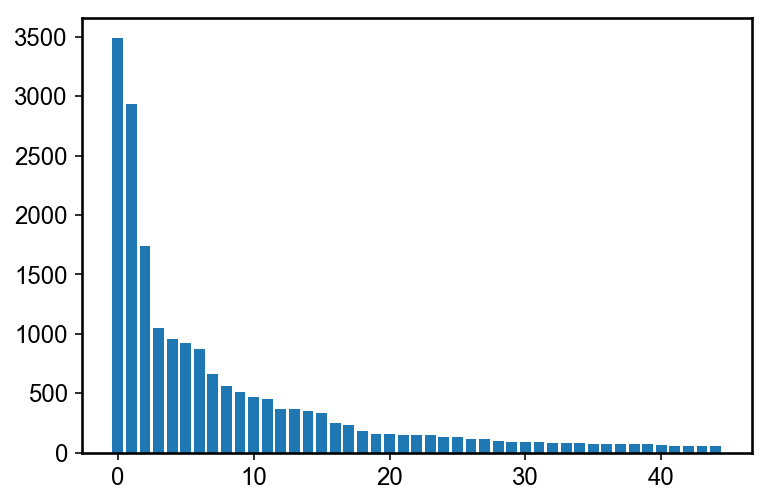

In [342]:
counts = countpatent[countpatent['grant_doc_num']>50]
plt.bar(range(len(counts)), counts['grant_doc_num'])

<Container object of 74 artists>

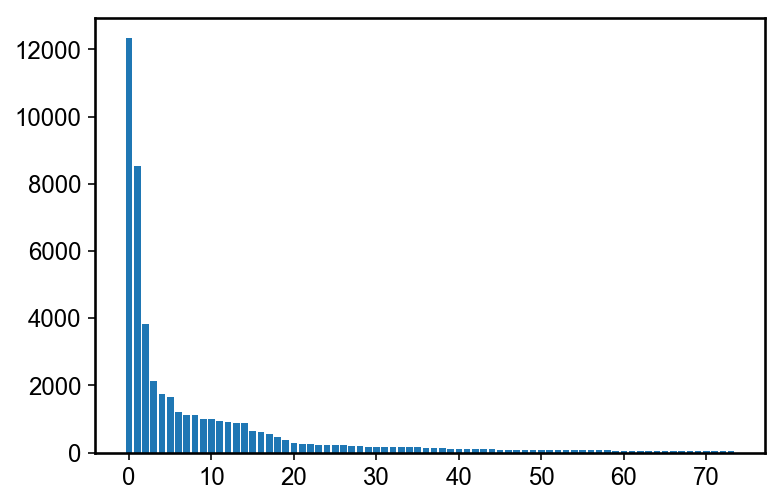

In [339]:
counts = countpatent[countpatent['grant_doc_num']>50]
plt.bar(range(len(counts)), counts['grant_doc_num'])

In [343]:
average = np.average(counts['grant_doc_num'])
average

426.66666666666669

In [344]:
# np.percentile(counts['grant_doc_num'], q=[33, 66,100])
pctile_66 = np.percentile(counts['grant_doc_num'],66.7)
pctile_33 = np.percentile(counts['grant_doc_num'],33.4)

In [345]:
high = counts[counts['grant_doc_num']>pctile_66]
medium = counts[(counts['grant_doc_num']>pctile_33) & (counts['grant_doc_num']<=pctile_66)]
low = counts[counts['grant_doc_num']<=pctile_33]

In [346]:
print('high category company count:', len(high))
print('medium category company count:',len(medium))
print('low category company count:',len(low))

high category company count: 15
medium category company count: 15
low category company count: 15


In [347]:
high_ticker = list(high['ticker'])
medium_ticker = list(medium['ticker'])
low_ticker = list(low['ticker'])

In [360]:
# temp = dict()

In [361]:
def get_stock_data(ticker, temp):
    if ticker in temp:
        return (temp[ticker],0)
    else:
        api_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&outputsize=full&apikey=8DZ1S71GQ2XPK9JD'.format(ticker)
        session = requests.Session()
        session.mount('http://', requests.adapters.HTTPAdapter(max_retries=3))
        raw_data = session.get(api_url)
        txt = raw_data.json()
        if list(txt.keys())[0] == 'Error Message':
            return None
        else:
            data = pd.DataFrame(txt['Time Series (Daily)']).T.reset_index()
            data = data[['index','5. adjusted close']]
            data.columns=['date', 'adj. close']
            data = data.sort_values("date", ascending=True)
            temp[ticker] = data
            return (data, temp)

def get_data_year(y_min, y_max, data):
    lowerbd_st = data[data['date']>y_min]
    stock_price = lowerbd_st[lowerbd_st['date']<y_max]
    return stock_price 


def get_return(df, ticker):
    df['yesterday']=df['adj. close'].shift(1)
    title = ticker+' return'
    df[title] = (df['adj. close'].astype(float)-df['yesterday'].astype(float))/df['yesterday'].astype(float)
    return df[['date',title]]

In [364]:
y_min = '2013'
y_max = '2016'

return_list = []

for ticker in tqdm(high_ticker):
    data = get_stock_data(ticker, temp)
    if data is not None:
        stock_price=get_data_year(y_min, y_max, data[0])
        returns = get_return(stock_price, ticker)
        return_list.append(returns)


100%|██████████| 15/15 [00:03<00:00,  5.09it/s]


In [366]:
# return_list

In [349]:
return_list_med = []

for ticker in tqdm(medium_ticker):
    stock_price = get_stock_data(ticker, y_min, y_max, temp)[0]
    returns = get_return(stock_price, ticker)
    return_list_med.append(returns)

100%|██████████| 15/15 [00:00<00:00, 532.33it/s]


In [350]:
return_list_low = []

for ticker in tqdm(low_ticker):
    stock_price = get_stock_data(ticker, y_min, y_max, temp)[0]
    returns = get_return(stock_price, ticker)
    return_list_low.append(returns)

100%|██████████| 15/15 [00:00<00:00, 485.32it/s]


In [351]:
df = return_list[0]
for i in return_list[1:]:
    if len(i)>0:
        df=df.merge(i, on='date', how='outer')
        
df_med = return_list_med[0]
for i in return_list_med[1:]:
    if len(i)>0:
        df_med=df_med.merge(i, on='date', how='outer')
        
df_low = return_list_low[0]
for i in return_list_low[1:]:
    if len(i)>0:
        df_low=df_low.merge(i, on='date', how='outer')

In [352]:
high_mean = df.mean(axis=1)
med_mean = df_med.mean(axis=1)
low_mean = df_low.mean(axis=1)

In [353]:
df_returns = high_mean.to_frame("High").\
    join(med_mean.to_frame("Mid")).\
    join(low_mean.to_frame("Low")).dropna()

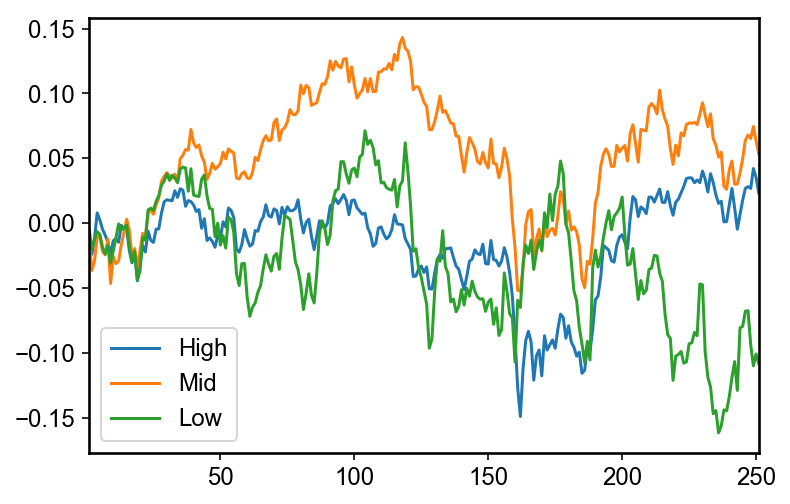

In [354]:
df_returns.cumsum().plot()